# Treino do modelo

In [1]:
import os
import sys

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from Functions.Pipeline import pipeline_completa_skus
from Functions.FNC_Pro import lista_produtos, configurar_credenciais_bq,produtos_selecionados

configurar_credenciais_bq(r'G:Drives compartilhados/Bases BI/epoca-230913-b478a9a0dd4c.json')

# --- Caminho para lista personalizada de produtos ---

""" 
Colocar o caminho do arquivo excel (.xlsx) com a lista dos produtos que você deseja treinar

Ex: produtos_selecionado(Documents/Planilhas/Lista_produtos.xlsx)

Depois é só substituir na função abaixo lista_produtos colocando a variável SKUS = lista_selecionados

"""

lista_selecionados = produtos_selecionados('C:/Users/joao.pcarvalho/Desktop/Git Repositórios/Forecast-vendas-e-elasticidade/Lista Produtos/Lista.xlsx')


# --- Definir filtros para os produtos ---
produtos = lista_produtos(
    'G:/Drives compartilhados/Planilha de Impostos/BI/Planilha com Impostos.xlsm',
    SKUS= lista_selecionados
)

# --- Instruções do lista_produtos ---

""" 
Classificacao = A ou B ou C
Ativo = Sim ou Nao
SKUS = ['sku1','sku2','sku3','sku4']
SKUS = lista_selecionados

"""

# --- Executar pipeline de treinamento ---
# Esta etapa apenas treina os modelos, salva os arquivos e gera o relatório de comparação.
resultados_consolidados = pipeline_completa_skus(
    df_produtos=produtos,
    n_splits=10
)

print("\nResultados consolidados do treinamento:")
display(resultados_consolidados.head())

Encontrados 17 SKUs com os filtros: Classificação='None', Ativo='None', SKUs='['80625', '77244', '52251', '71248', '9891', '58407', '7172', '30717', '42891', '36949', '10036', '88308', '81379', '77243', '83626', '34891', '21120']'
--- INICIANDO PIPELINE DE TREINAMENTO DE MODELOS ---
Total de SKUs para processar: 17
------------------------------------------------------------

>>> Processando SKU 52251 (1/17) <<<
SKU 52251: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
  Modelo TSCV:
    AIC: 2286.92, BIC: 2303.06
    Coeficientes: [-3.81780422  0.52085738  0.2017916 ]
  Modelo ARIMAX:
    AIC: 3081.19, BIC: 3120.47
    Coeficientes: {'intercept': -1.121307958603898, 'Log_Preco': 3.550845868952944, 'Quarta-feira': 0.22959711939797461, 'Terça-feira': 0.21597967609966998, 'ar.L1': 0.6744577873641391, 'ar.L2': 0.09606485535152694, 'ar.L3': 0.13027233014604814, 'sigma2': 1.2474330061398304}

>>> Processando SKU 80625 (2/17) <<<
SKU 80625: Histórico de da

,sku,data_rodagem,modelo_ideal,intercepto_tscv,coef_log_preco_tscv,coef_quarta-feira_tscv,coef_terça-feira_tscv,intercepto_sarimax,coef_log_preco_sarimax,coef_quarta-feira_sarimax,coef_terça-feira_sarimax,AIC_sarimax,BIC_sarimax,AIC_cruzado,BIC_cruzado
0,52251,2025-10-01 11:36:47,ARIMAX,18.405365,-3.817804,0.520857,0.201792,-1.121308,3.550846,0.229597,0.215980,3081.193776,3120.471802,2286.922042,2303.058158
1,80625,2025-10-01 11:37:08,TSCV,31.978631,-6.717069,0.213864,0.373524,2.584338,-5.420632,0.026463,0.146042,1603.368338,1640.090746,1424.959050,1439.846477
2,58407,2025-10-01 11:37:35,ARIMAX,-17.017820,5.089933,0.267331,0.379880,-0.908791,8.858034,0.045892,0.053310,3727.768858,3771.938655,2533.066002,2549.176806
3,9891,2025-10-01 11:37:46,ARIMAX,17.951516,-3.955475,0.273817,0.263543,0.937293,0.154563,0.092285,0.063852,3272.072614,3316.260393,2298.715970,2314.852086
4,71248,2025-10-01 11:38:08,TSCV,25.367772,-5.070345,0.417646,0.299249,7.873579,-4.213984,0.133918,0.136540,2633.475303,2667.836587,1784.805587,1800.916391


# Teste do modelo

--- INICIANDO PREVISÕES COM BASE NO ARQUIVO DE PREÇOS ---
--- INICIANDO PREVISÃO A PARTIR DE MODELOS SALVOS ---
Encontrados 17 SKUs no arquivo de preços.
  Processando SKU: 7172
  Processando SKU: 10036
  Processando SKU: 21120
  Processando SKU: 80625
  Processando SKU: 77244
  Processando SKU: 52251
  Processando SKU: 71248
  Processando SKU: 9891
  Processando SKU: 58407
  Processando SKU: 30717
  Processando SKU: 42891
  Processando SKU: 36949
  Processando SKU: 88308
  Processando SKU: 81379
  Processando SKU: 77243
  Processando SKU: 83626
  Processando SKU: 34891

--- PREVISÃO CONCLUÍDA ---

Arquivo de previsões consolidado salvo em: c:\Users\joao.pcarvalho\Desktop\Git Repositórios\Forecast-vendas-e-elasticidade\Resultados\previsoes_consolidado.csv

Amostra das previsões geradas a partir do arquivo de preços:


,Data,SKU,Preco,previsao_TSCV,previsao_SARIMAX
0,2025-09-18,7172,379.0,9.711848,8.187749
1,2025-09-19,7172,375.0,10.232026,0.662830
2,2025-09-20,7172,370.0,10.930213,2.106519
3,2025-09-21,7172,369.0,11.076651,22.284715
4,2025-09-22,7172,329.0,19.473843,18.927325




--- INICIANDO PREVISÕES DE 30 DIAS PARA O FUTURO ---
SKUs encontrados no arquivo de preços para gerar previsões futuras: ['7172', '10036', '21120', '80625', '77244', '52251', '71248', '9891', '58407', '30717', '42891', '36949', '88308', '81379', '77243', '83626', '34891']

--- Gerando previsão de 30 dias para o SKU: 7172 ---
SKU 7172: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 7172) ---
Último preço registrado: 298.34 em 2025-10-01
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_7172.png


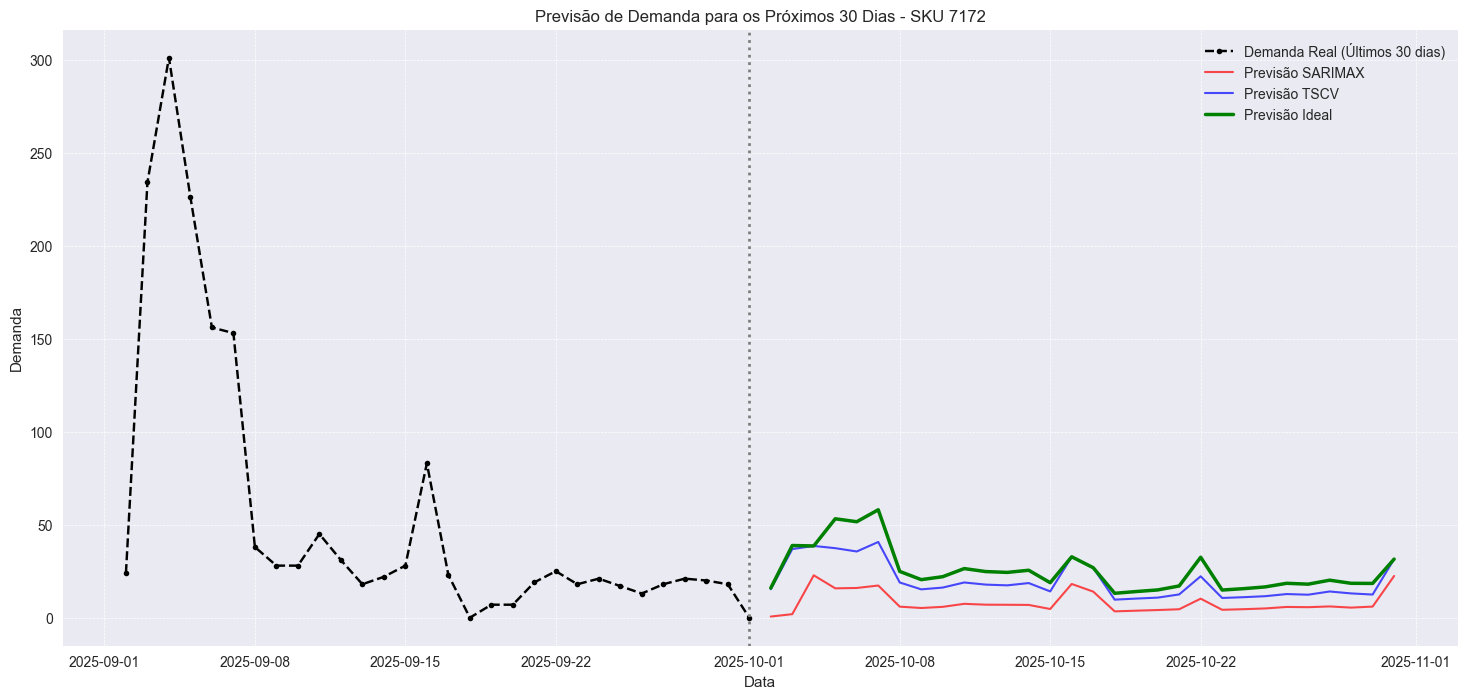


--- Gerando previsão de 30 dias para o SKU: 10036 ---
SKU 10036: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 10036) ---
Último preço registrado: 60.63 em 2025-10-01
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_10036.png


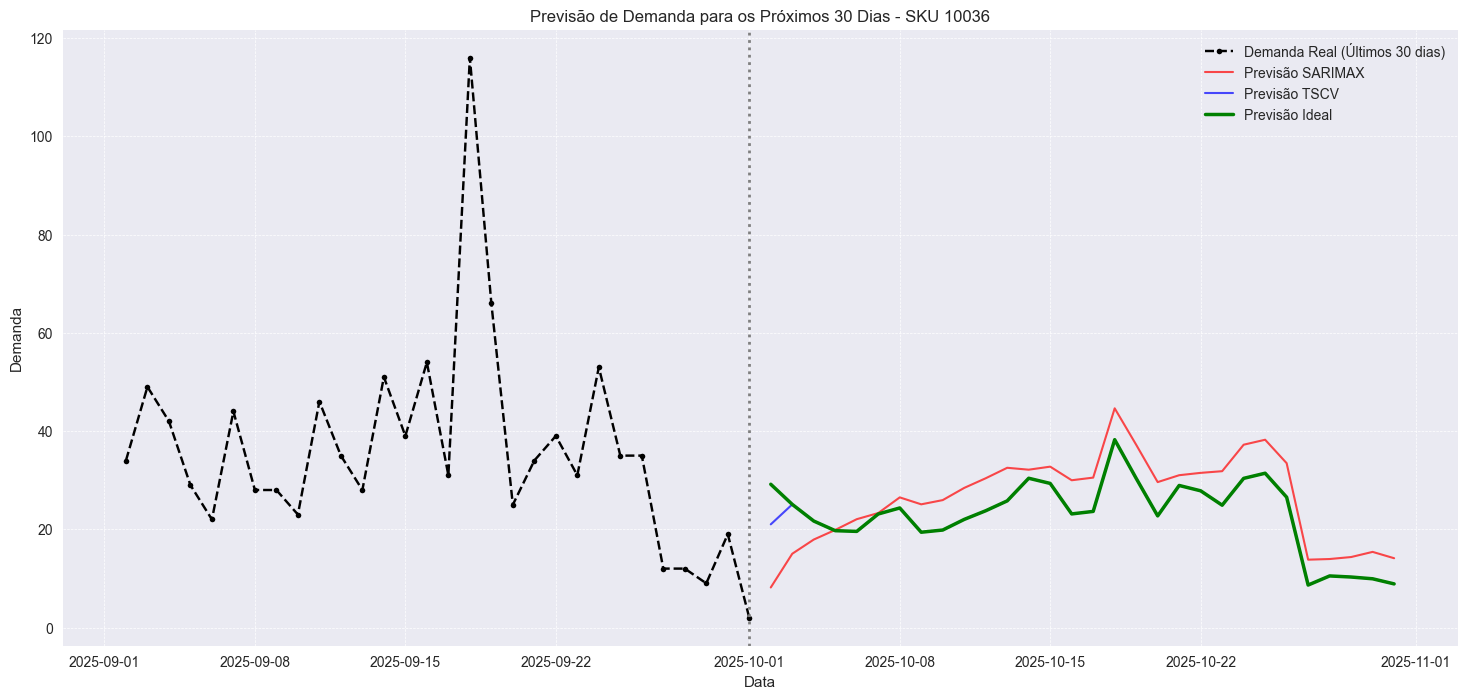


--- Gerando previsão de 30 dias para o SKU: 21120 ---
SKU 21120: Histórico de dados ajustado para começar em 2023-01-02, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 21120) ---
Último preço registrado: 54.20 em 2025-10-01
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_21120.png


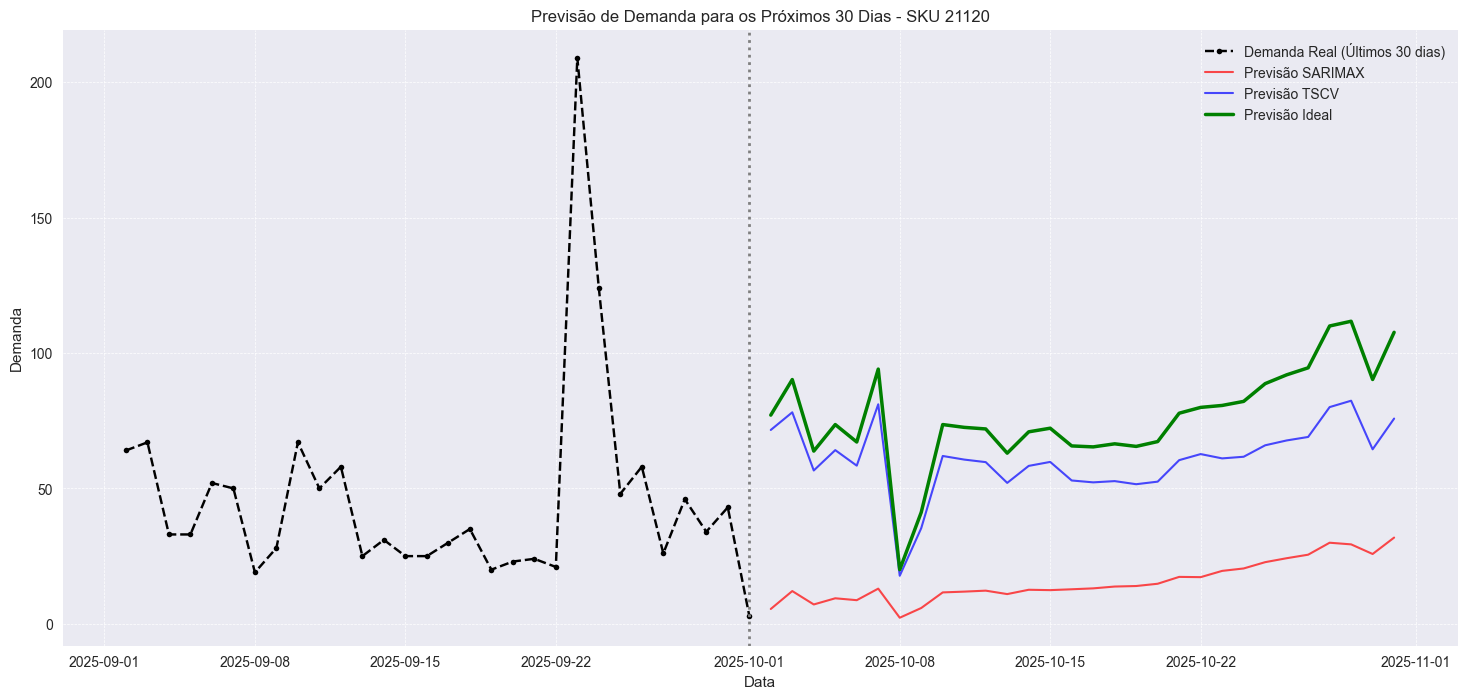


--- Gerando previsão de 30 dias para o SKU: 80625 ---
SKU 80625: Histórico de dados ajustado para começar em 2023-10-02, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 80625) ---
Último preço registrado: 69.79 em 2025-10-01
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_80625.png


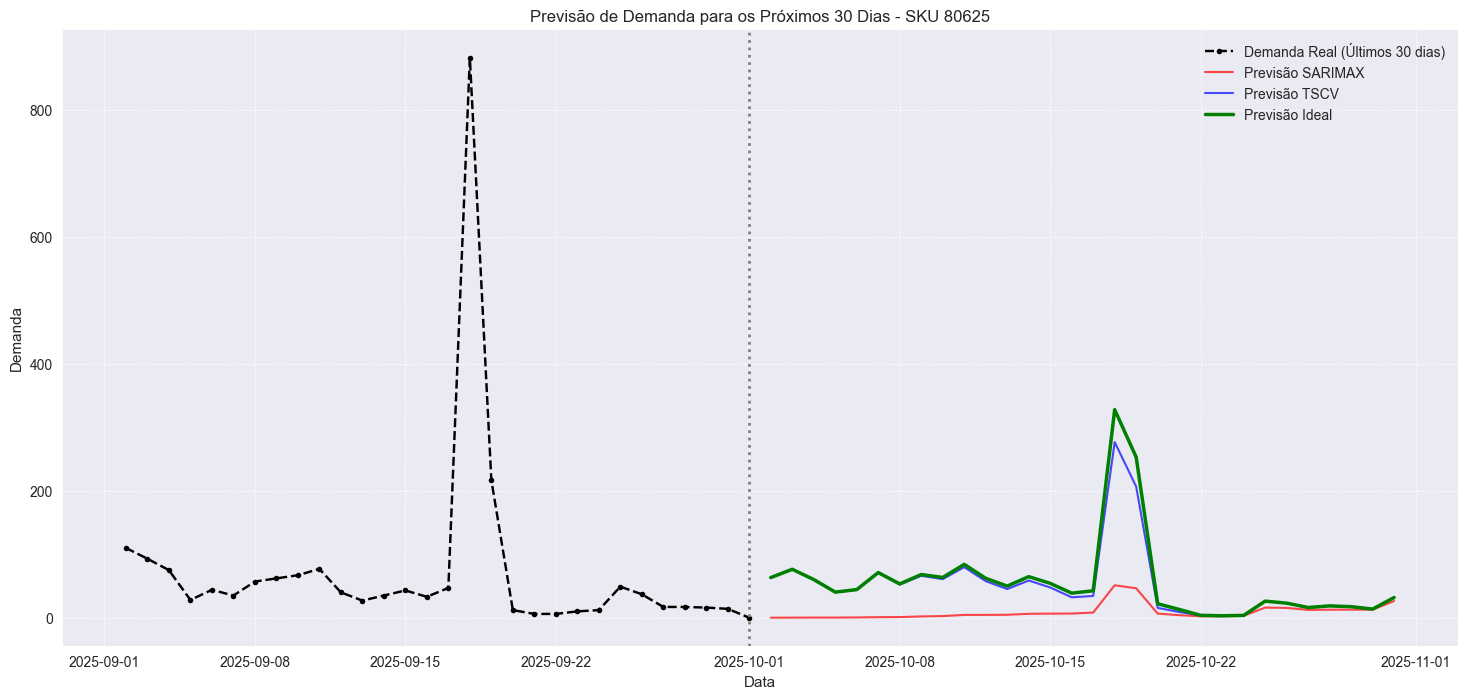


--- Gerando previsão de 30 dias para o SKU: 77244 ---
SKU 77244: Histórico de dados ajustado para começar em 2023-06-02, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 77244) ---
Último preço registrado: 75.90 em 2025-10-01
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_77244.png


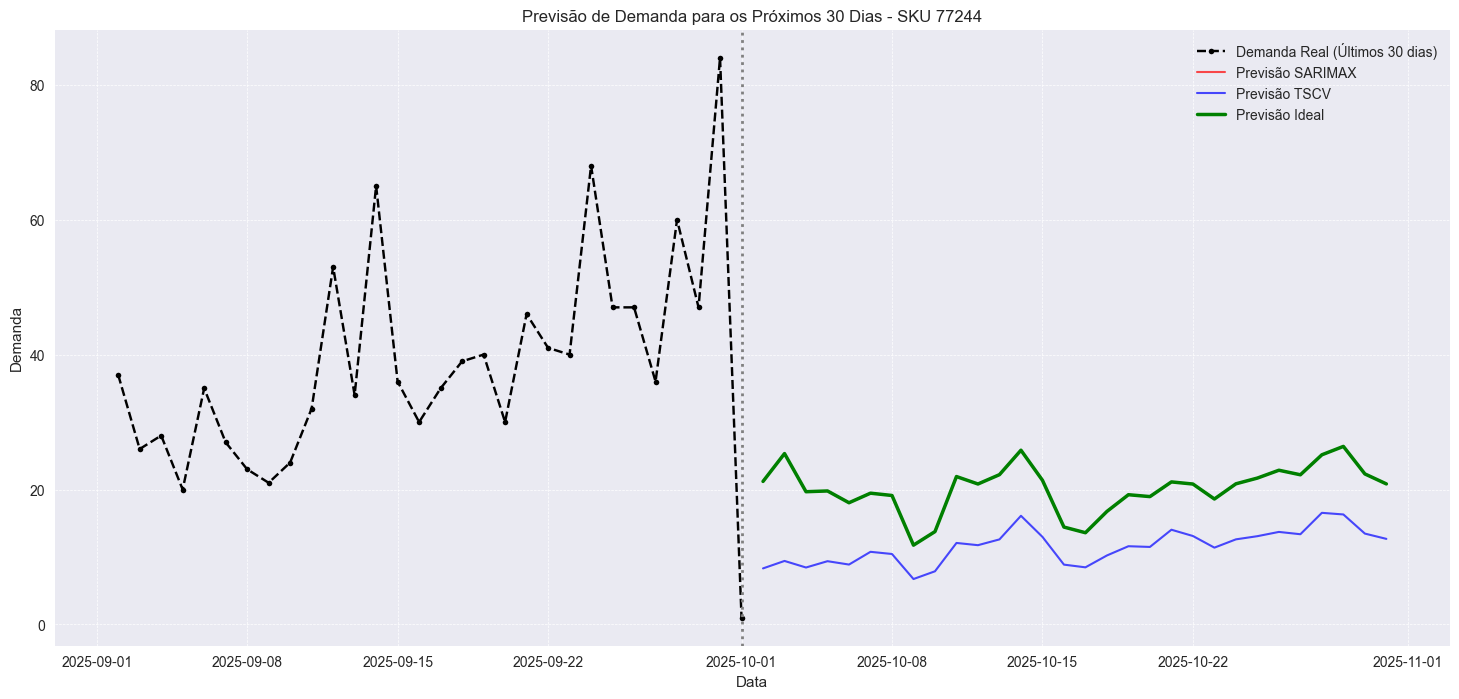


--- Gerando previsão de 30 dias para o SKU: 52251 ---
SKU 52251: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 52251) ---
Último preço registrado: 60.61 em 2025-10-01
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_52251.png


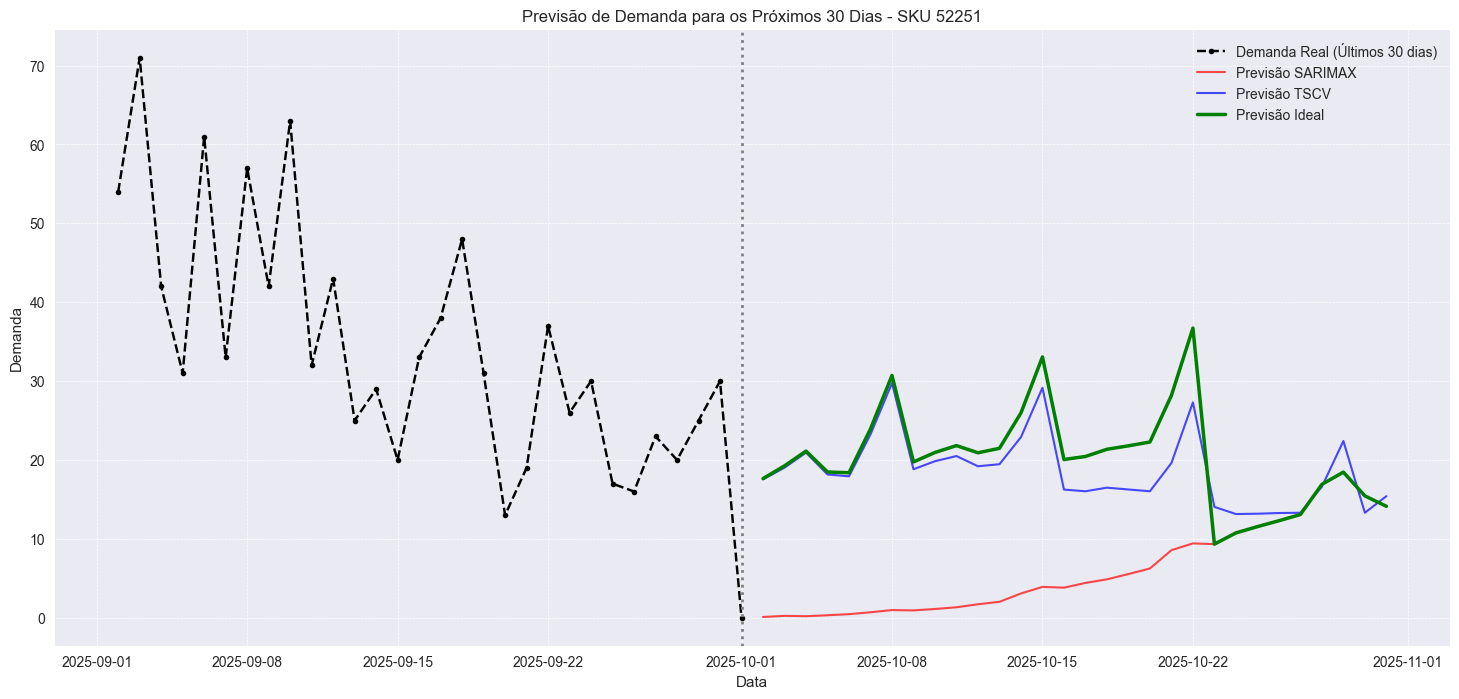


--- Gerando previsão de 30 dias para o SKU: 71248 ---
SKU 71248: Histórico de dados ajustado para começar em 2023-01-03, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 71248) ---
Último preço registrado: 88.90 em 2025-10-01
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_71248.png


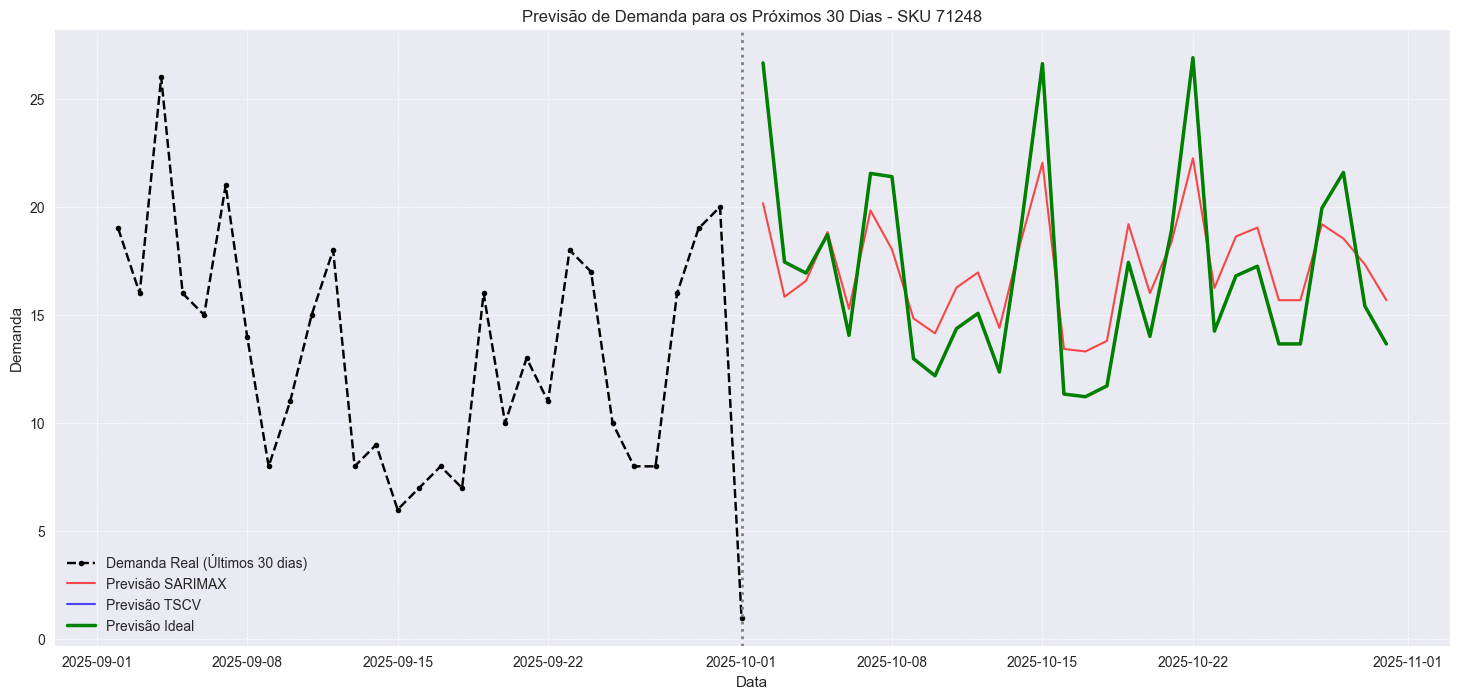


--- Gerando previsão de 30 dias para o SKU: 9891 ---
SKU 9891: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 9891) ---
Último preço registrado: 36.95 em 2025-10-01
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_9891.png


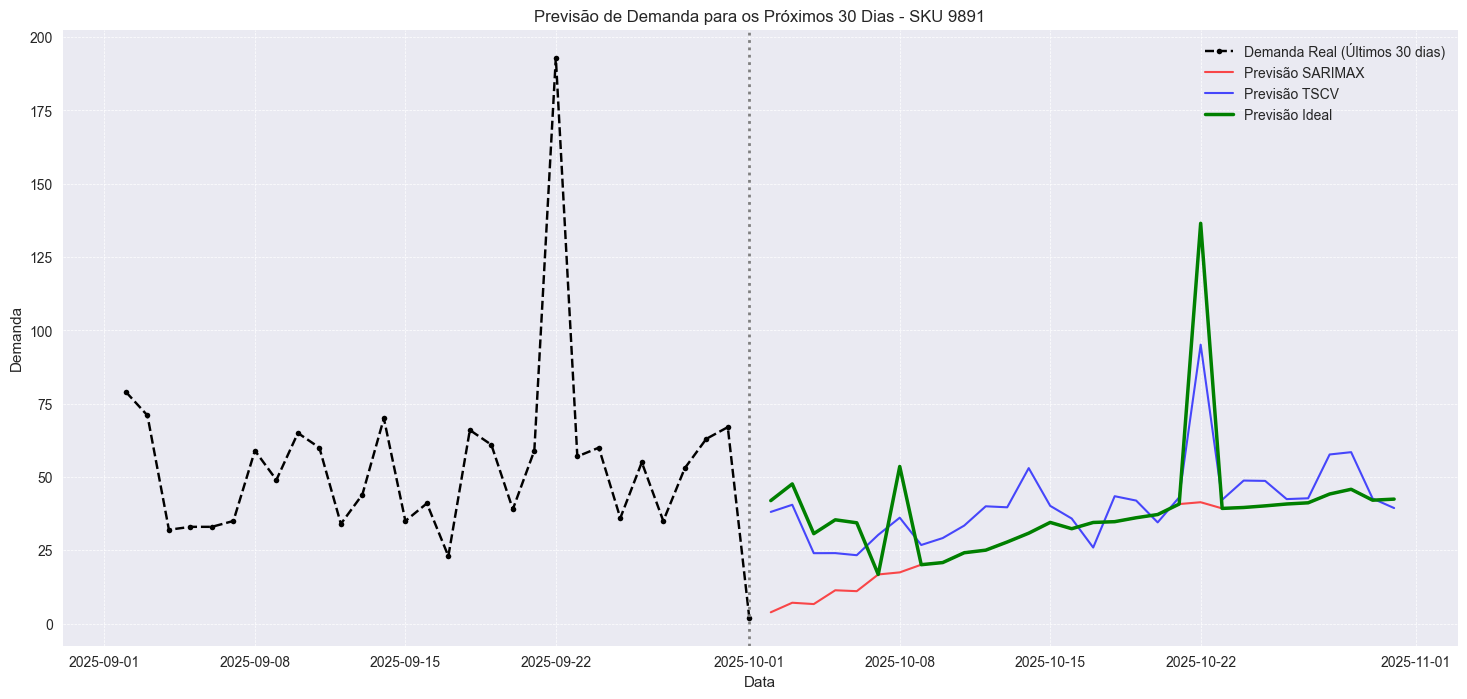


--- Gerando previsão de 30 dias para o SKU: 58407 ---
SKU 58407: Histórico de dados ajustado para começar em 2023-01-03, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 58407) ---
Último preço registrado: 16.71 em 2025-10-01
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_58407.png


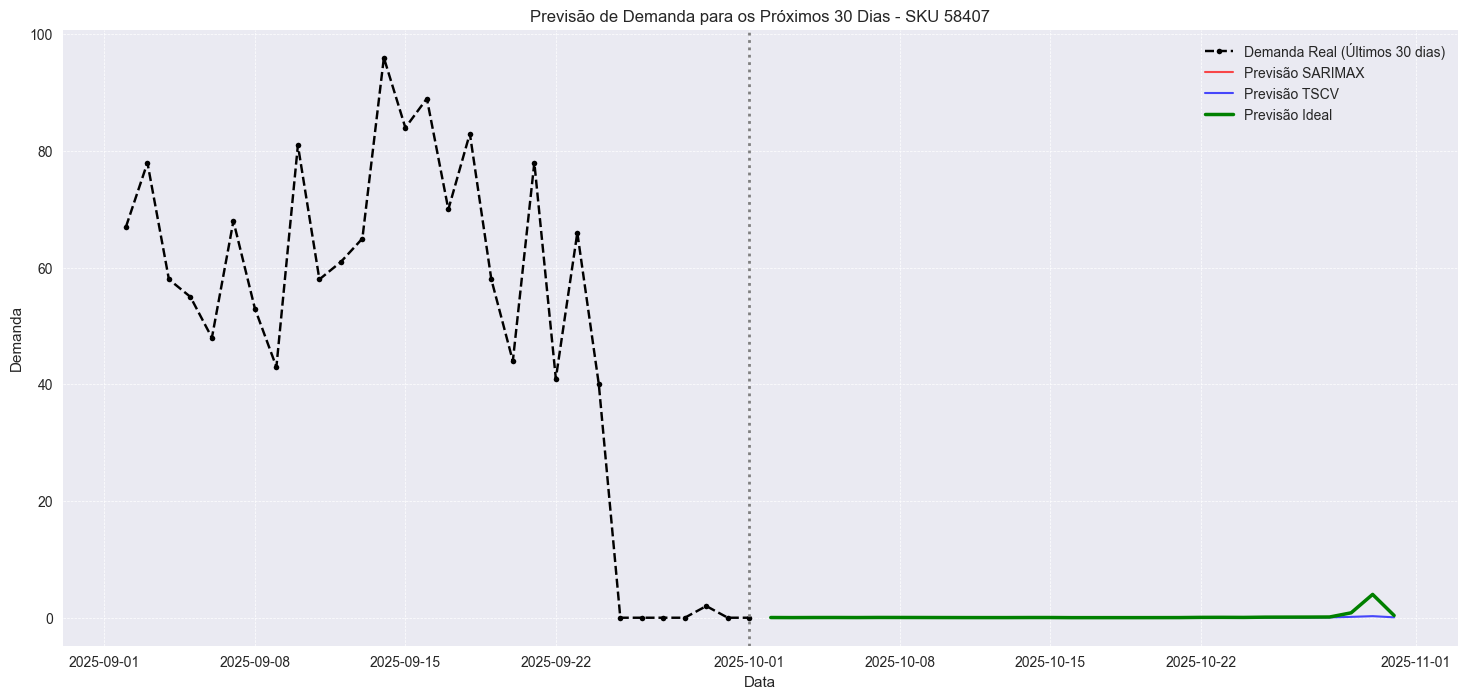


--- Gerando previsão de 30 dias para o SKU: 30717 ---
SKU 30717: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 30717) ---
Último preço registrado: 59.90 em 2025-10-01
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_30717.png


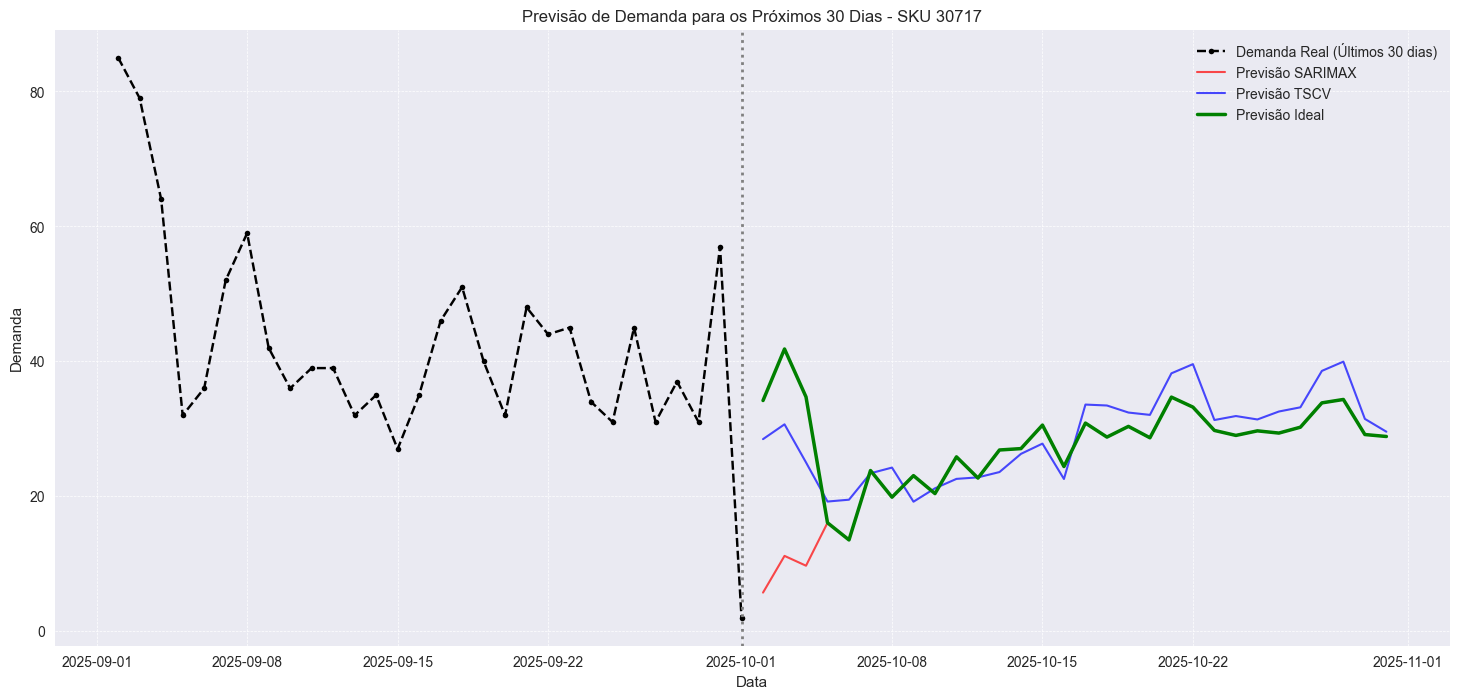


--- Gerando previsão de 30 dias para o SKU: 42891 ---
SKU 42891: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 42891) ---
Último preço registrado: 21.86 em 2025-10-01
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_42891.png


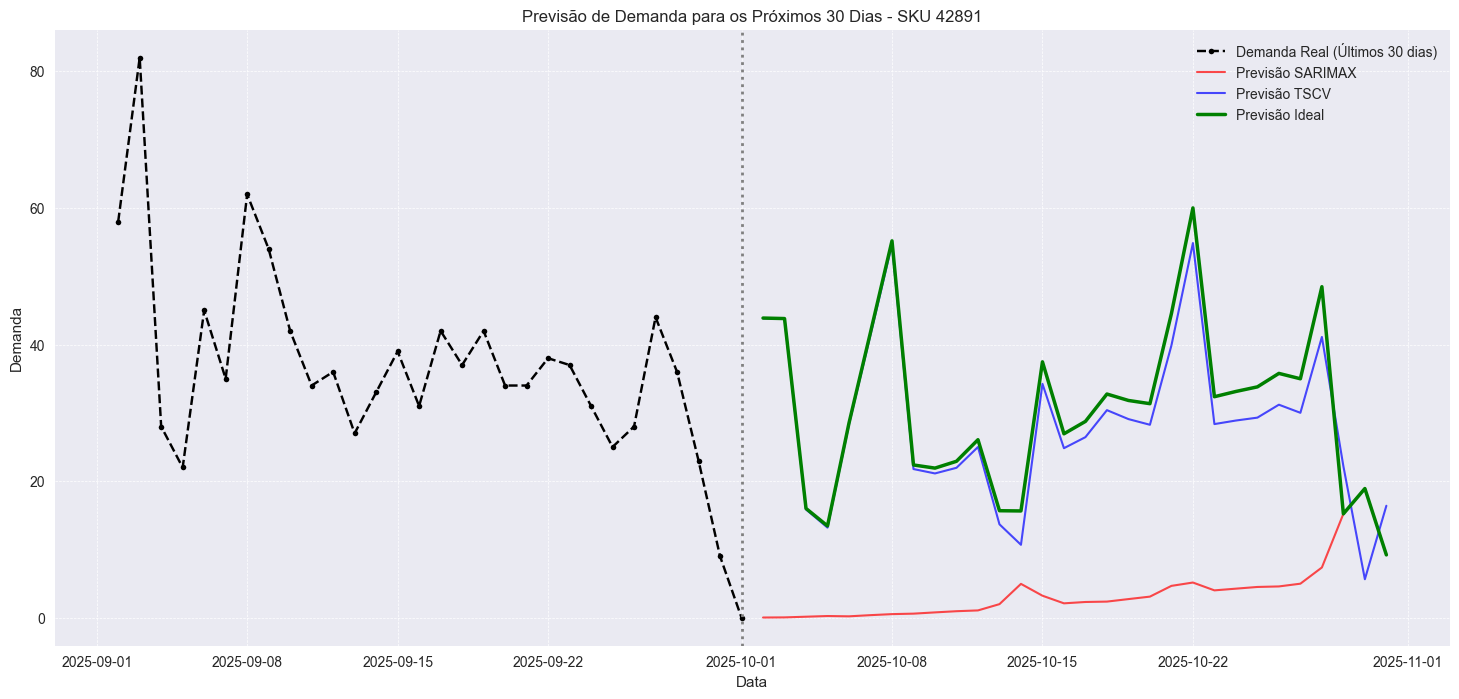


--- Gerando previsão de 30 dias para o SKU: 36949 ---
SKU 36949: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 36949) ---
Último preço registrado: 99.90 em 2025-10-01
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_36949.png


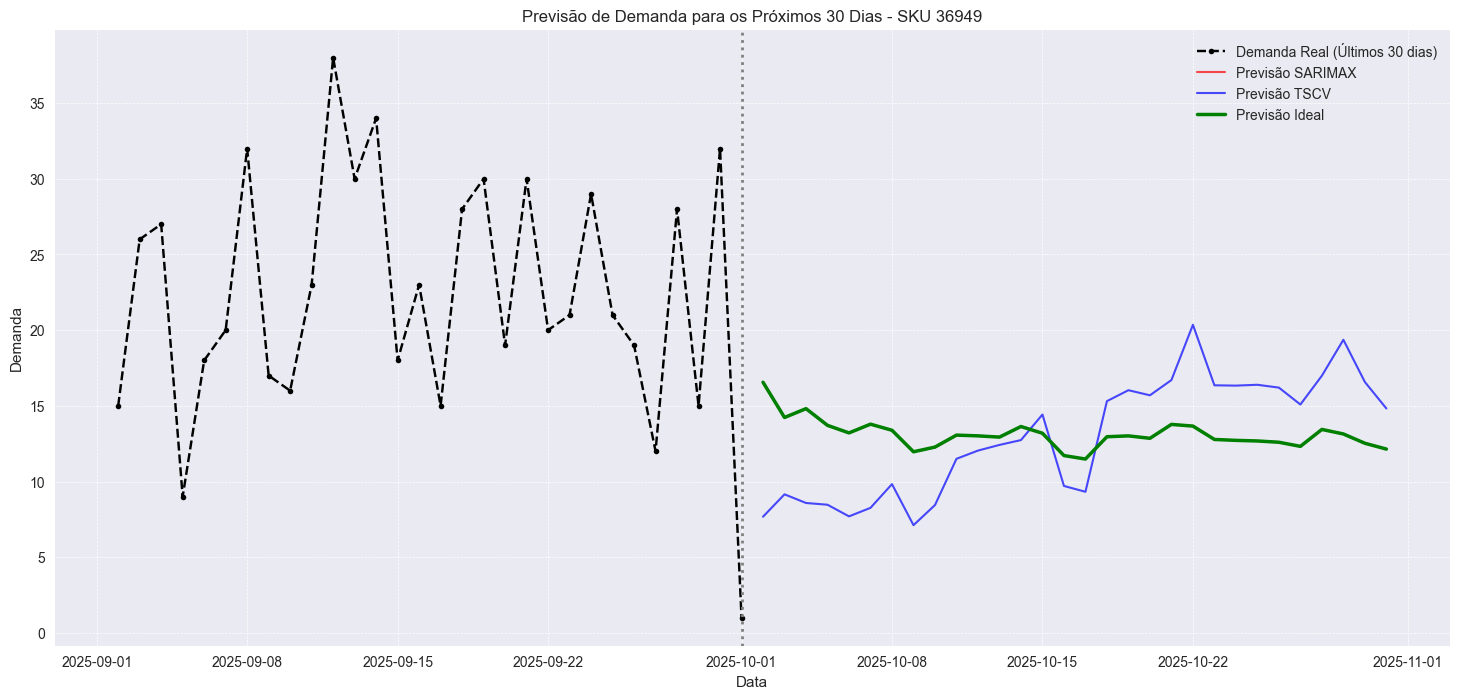


--- Gerando previsão de 30 dias para o SKU: 88308 ---
SKU 88308: Histórico de dados ajustado para começar em 2024-08-31, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 88308) ---
Último preço registrado: 28.73 em 2025-10-01
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_88308.png


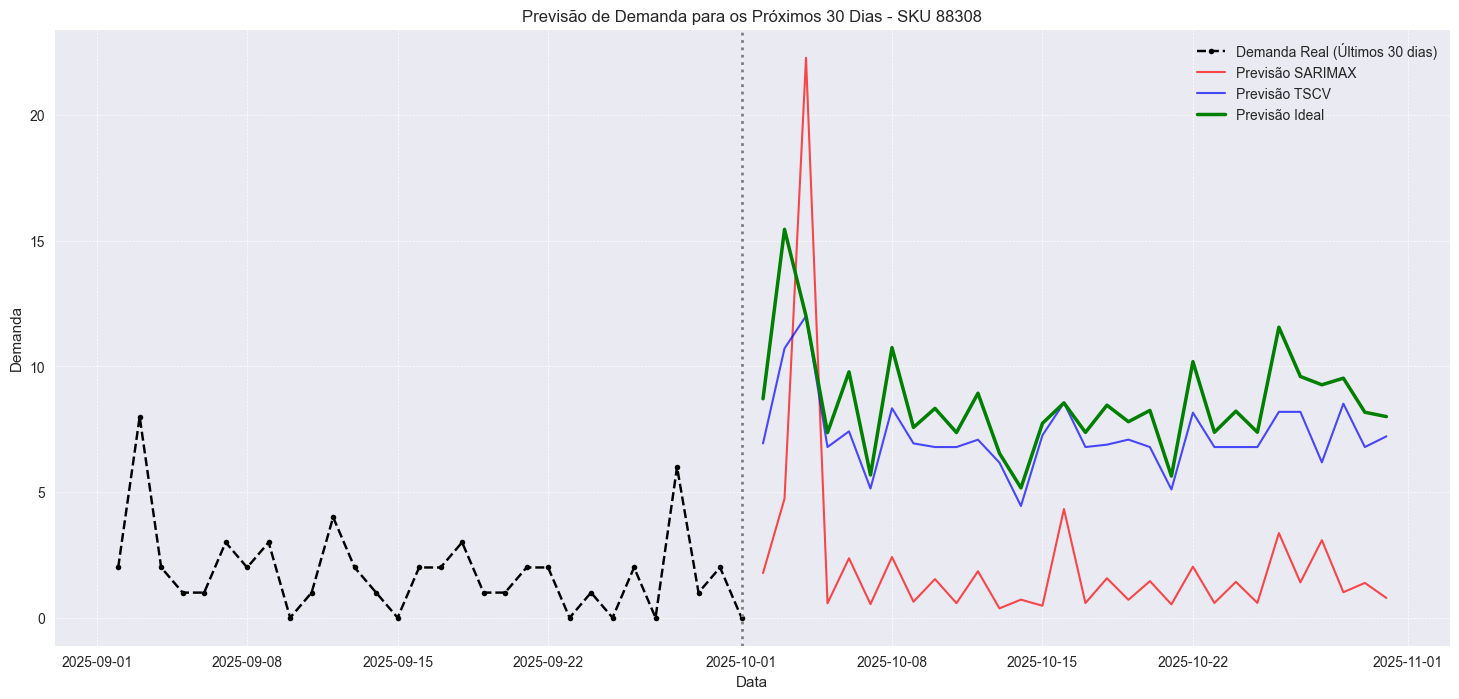


--- Gerando previsão de 30 dias para o SKU: 81379 ---
SKU 81379: Histórico de dados ajustado para começar em 2023-12-21, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 81379) ---
Último preço registrado: 46.71 em 2025-10-01
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_81379.png


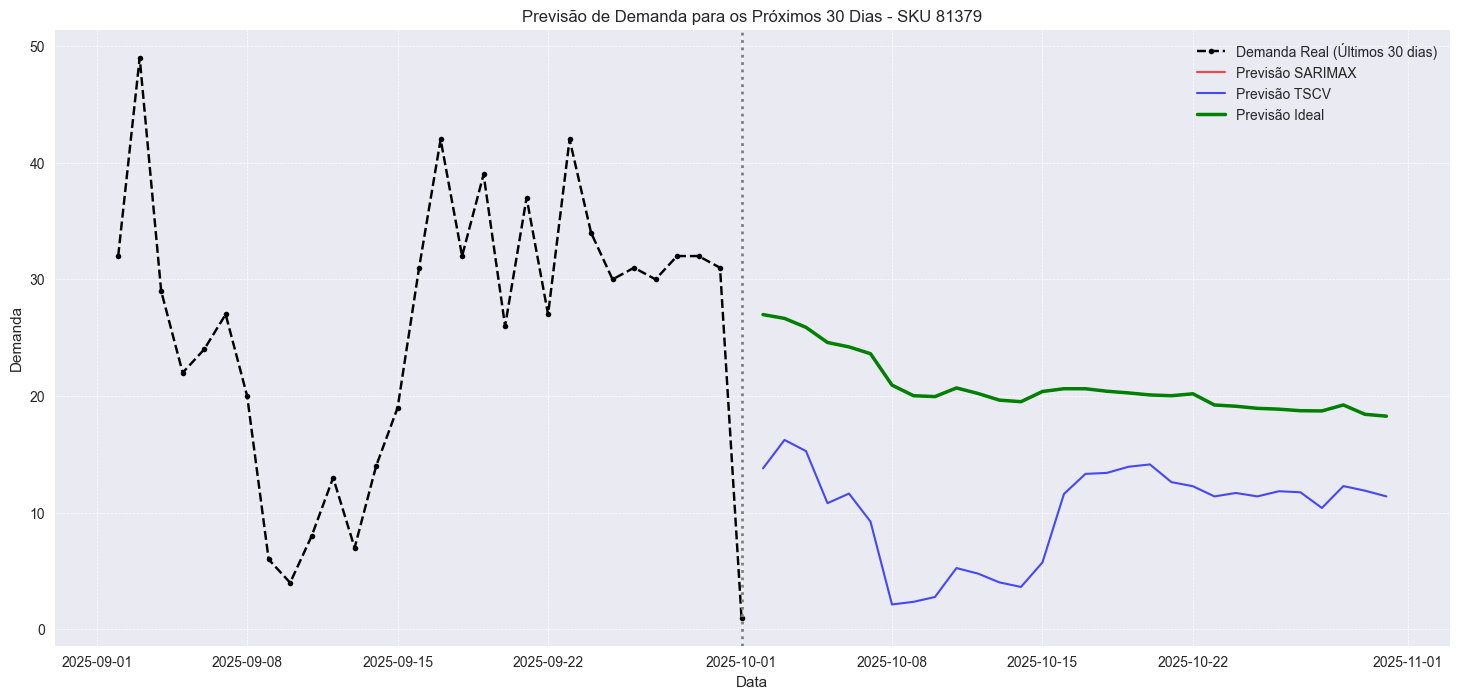


--- Gerando previsão de 30 dias para o SKU: 77243 ---
SKU 77243: Histórico de dados ajustado para começar em 2023-06-02, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 77243) ---
Último preço registrado: 38.85 em 2025-10-01
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_77243.png


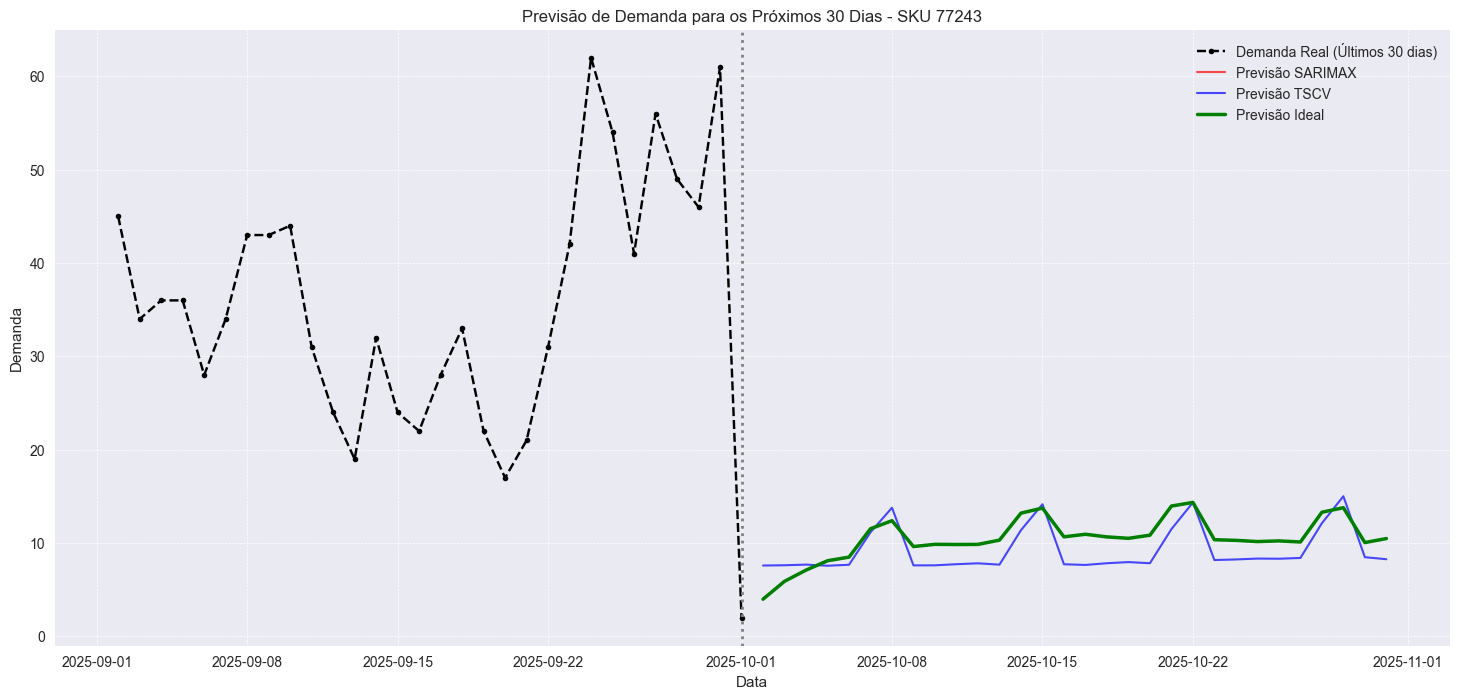


--- Gerando previsão de 30 dias para o SKU: 83626 ---
SKU 83626: Histórico de dados ajustado para começar em 2024-04-03, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 83626) ---
Último preço registrado: 702.05 em 2025-10-01
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_83626.png


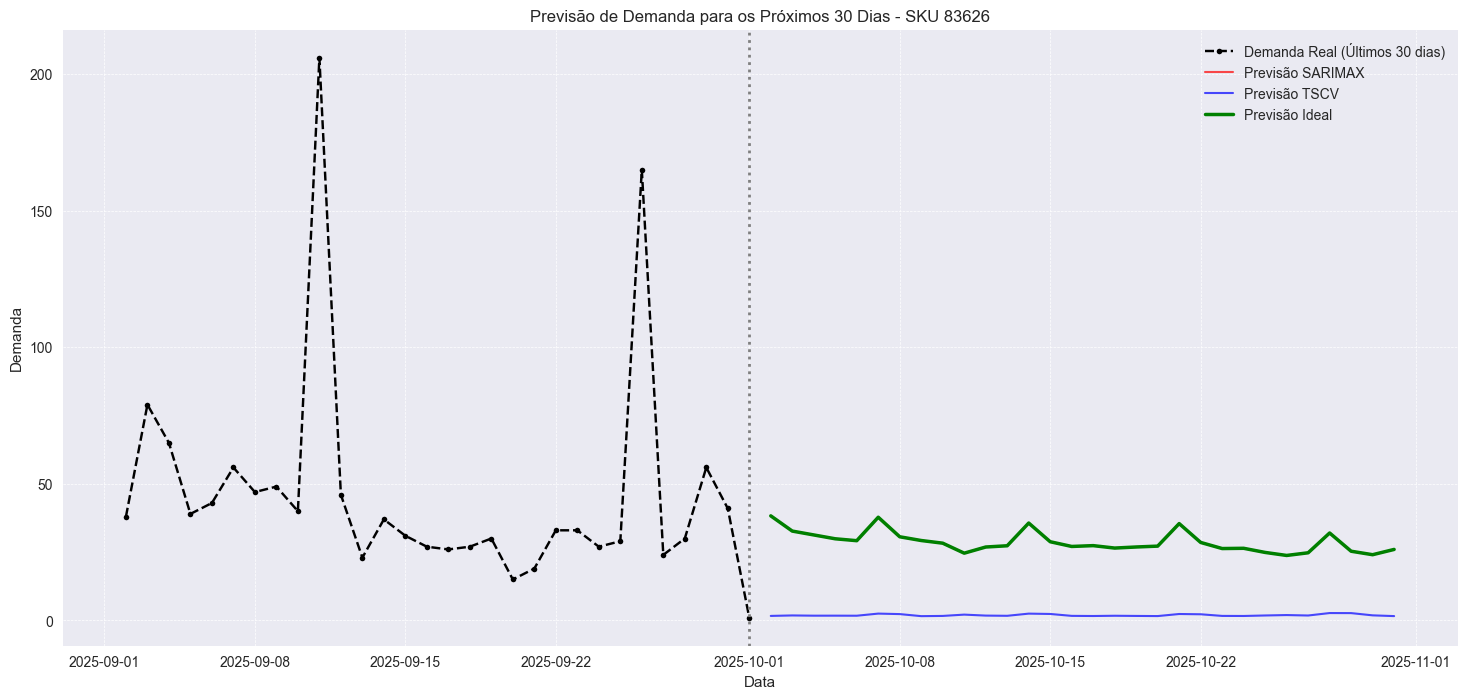


--- Gerando previsão de 30 dias para o SKU: 34891 ---
SKU 34891: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 34891) ---
Último preço registrado: 119.90 em 2025-10-01
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_34891.png


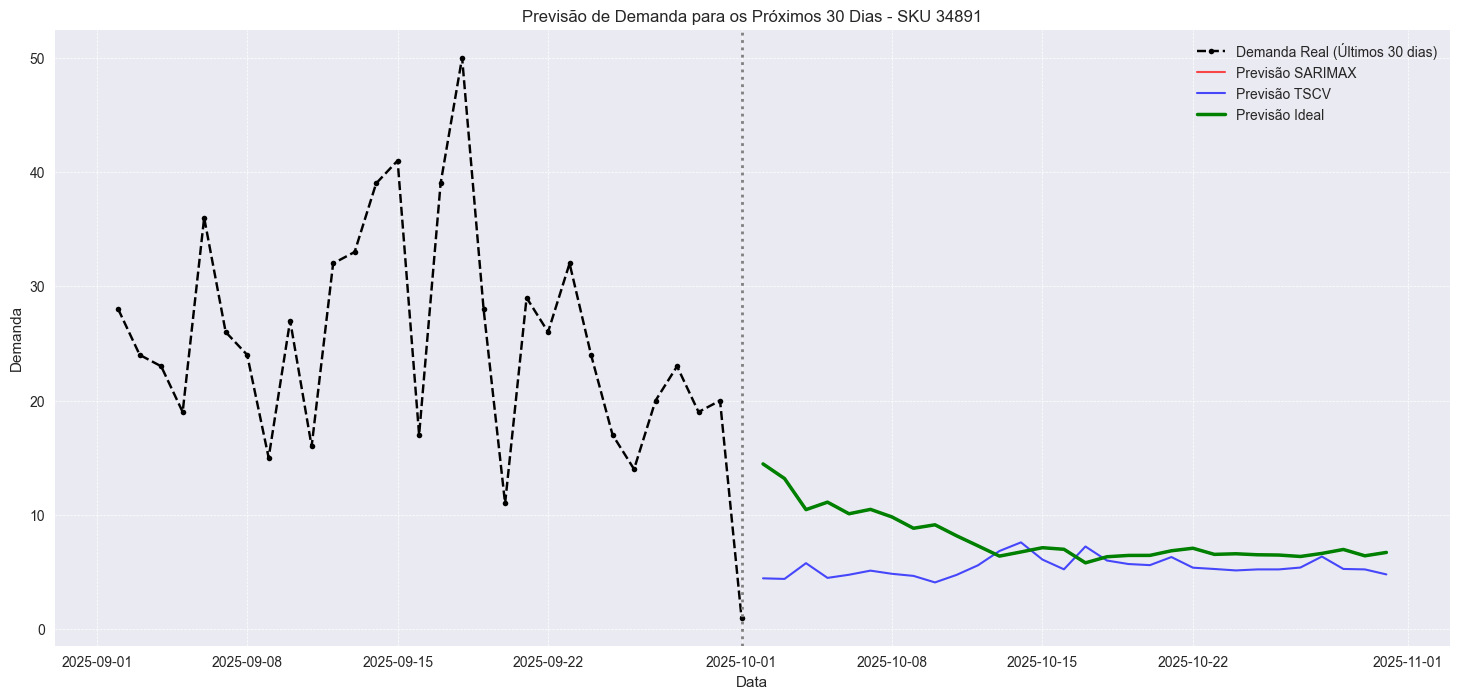


Arquivo de previsões futuras consolidado salvo em: c:\Users\joao.pcarvalho\Desktop\Git Repositórios\Forecast-vendas-e-elasticidade\Resultados\previsoes_futuras_consolidado.csv

Amostra das previsões de 30 dias consolidadas:


,Data,SKU,Preco,Log_Preco,Quarta-feira,Terça-feira,previsao_TSCV,previsao_SARIMAX,previsao_total
0,2025-10-02,7172,345.51,5.845022,0,0,15.306701,0.635526,15.942227
1,2025-10-03,7172,288.91,5.666115,0,0,36.894755,1.912180,38.806935
2,2025-10-04,7172,286.30,5.657040,0,0,38.578538,22.786675,38.578538
3,2025-10-05,7172,288.14,5.663446,0,0,37.382141,15.792336,53.174477
4,2025-10-06,7172,291.01,5.673358,0,0,35.603879,15.989749,51.593628


In [2]:
import os
import sys
import pandas as pd
from IPython.display import display
import joblib
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from Functions.FNC_Previsoes import prever_demanda_com_modelos_salvos, pred_prox_30_dias
from Functions.FNC_Pro import Base_venda

# --- Definir os caminhos ---
caminho_pasta_modelos = os.path.join(project_root, 'Modelos')
caminho_planilha_precos = os.path.join(project_root, 'Forecast', 'Precos_para_previsoes.xlsx')
caminho_resultados = os.path.join(project_root, 'Resultados')


# --- 1. Previsões com base no arquivo de preços ---
print("--- INICIANDO PREVISÕES COM BASE NO ARQUIVO DE PREÇOS ---")
df_previsoes_salvas = prever_demanda_com_modelos_salvos(
    caminho_pasta_modelos,
    caminho_planilha_precos
)

if not df_previsoes_salvas.empty:
    # Salvar o arquivo consolidado
    caminho_arquivo_consolidado = os.path.join(caminho_resultados, 'previsoes_consolidado.csv')
    df_previsoes_salvas.to_csv(caminho_arquivo_consolidado, index=False, sep=';', decimal=',')
    print(f"\nArquivo de previsões consolidado salvo em: {caminho_arquivo_consolidado}")
    
    print("\nAmostra das previsões geradas a partir do arquivo de preços:")
    display(df_previsoes_salvas.head())


# --- 2. Previsões de 30 dias para o futuro (com gráficos) ---
print("\n\n--- INICIANDO PREVISÕES DE 30 DIAS PARA O FUTURO ---")
try:
    df_precos = pd.read_excel(caminho_planilha_precos)
    skus_para_prever = df_precos['SKU'].astype(str).unique()
    print(f"SKUs encontrados no arquivo de preços para gerar previsões futuras: {list(skus_para_prever)}")
except FileNotFoundError:
    print(f"ERRO: Arquivo de preços não encontrado em '{caminho_planilha_precos}'")
    skus_para_prever = []

previsoes_futuras_consolidadas = []
if skus_para_prever.any():
    for sku in skus_para_prever:
        print(f"\n--- Gerando previsão de 30 dias para o SKU: {sku} ---")
        
        caminho_modelo_tscv = os.path.join(caminho_pasta_modelos, f'modelo_tscv_{sku}.joblib')
        caminho_modelo_sarimax = os.path.join(caminho_pasta_modelos, f'modelo_sarimax_{sku}.pkl')

        if not os.path.exists(caminho_modelo_tscv) or not os.path.exists(caminho_modelo_sarimax):
            print(f"  AVISO: Modelos para o SKU {sku} não encontrados. Pulando.")
            continue
        
        modelo_tscv = joblib.load(caminho_modelo_tscv)
        modelo_sarimax = SARIMAXResults.load(caminho_modelo_sarimax)
        Venda = Base_venda(sku)
        
        if Venda.empty:
            print(f"  AVISO: Não foi possível carregar o histórico de vendas para o SKU {sku}. Pulando.")
            continue

        df_previsao_futura = pred_prox_30_dias(
            modelo_tscv,
            modelo_sarimax,
            Venda,
            sku,
            X_cols_tscv=['Log_Preco', 'Quarta-feira', 'Terça-feira']
        )
        previsoes_futuras_consolidadas.append(df_previsao_futura)

if previsoes_futuras_consolidadas:
    df_previsoes_finais = pd.concat(previsoes_futuras_consolidadas, ignore_index=True)
    
    # Salvar o arquivo consolidado de previsões futuras
    caminho_futuro_consolidado = os.path.join(caminho_resultados, 'previsoes_futuras_consolidado.csv')
    df_previsoes_finais.to_csv(caminho_futuro_consolidado, index=False, sep=';', decimal=',')
    print(f"\nArquivo de previsões futuras consolidado salvo em: {caminho_futuro_consolidado}")

    print("\nAmostra das previsões de 30 dias consolidadas:")
    display(df_previsoes_finais.head())
else:
    print("\nNenhuma previsão de 30 dias foi gerada.")